<h1>Imports</h1>

In [73]:
import tensorflow as tf
TF_FORCE_GPU_ALLOW_GROWTH= True
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Using the CPU instead.")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomZoom, RandomFlip , RandomRotation
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import Dense , Dropout, BatchNormalization , GlobalAveragePooling2D , Conv2D , MaxPooling2D , Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , AveragePooling2D , Dropout
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ModelModifier
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.applications import MobileNetV2, VGG16, EfficientNetV2B0
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear



<h1> Load Dataset </h1>

In [74]:
from collections import Counter
trainining_data_path = 'brain_images/Training/' # Path to folder containing training image data
testing_data = 'brain_images/Testing/' # Path to folder containing testing image data

tf.random.set_seed(123)

BATCH_SIZE = 64 
IMAGE_SIZE = (150, 150)

image_paths_training = []
labels = []

for class_folder in os.listdir(trainining_data_path):
    class_folder_path = os.path.join(trainining_data_path, class_folder)
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_paths_training.append(os.path.join(class_folder_path, image_file))
                labels.append(class_folder)

image_paths_testing = []
testing_labels = []

for class_folder in os.listdir(testing_data):
    class_folder_path = os.path.join(testing_data, class_folder)
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_paths_testing.append(os.path.join(class_folder_path, image_file))
                testing_labels.append(class_folder)

print("Number of training images: ", len(image_paths_training))
print("Number of testing images: ", len(image_paths_testing))

label_counts_training = Counter(labels)
print("Label counts in training data: ", label_counts_training)

label_counts_testing = Counter(testing_labels)
print("Label counts in testing data: ", label_counts_testing)


Number of training images:  5712
Number of testing images:  1311
Label counts in training data:  Counter({'notumor': 1595, 'pituitary': 1457, 'meningioma': 1339, 'glioma': 1321})
Label counts in testing data:  Counter({'notumor': 405, 'meningioma': 306, 'pituitary': 300, 'glioma': 300})


<h1> Visualising Dataset</h1>

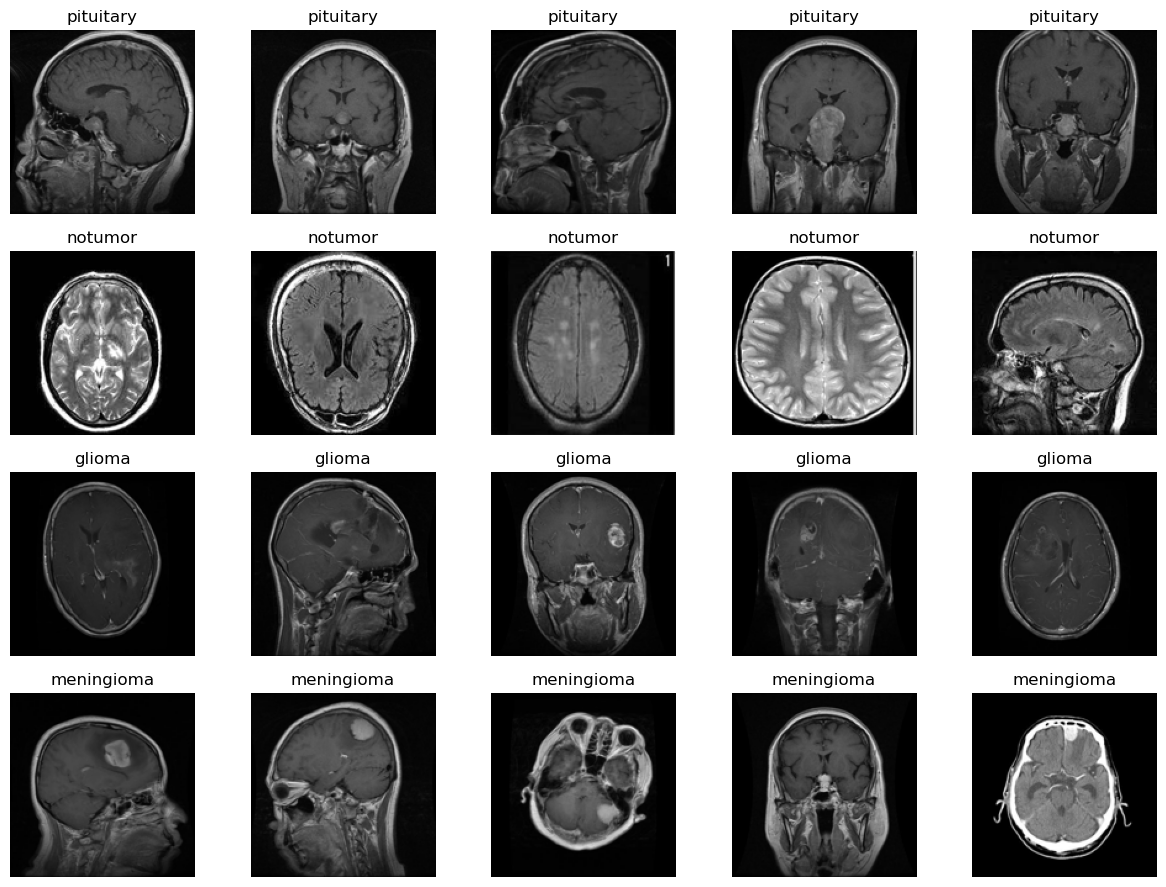

In [75]:
from PIL import Image
from collections import defaultdict

def load_images(image_paths, target_size):
    return np.array([np.array(Image.open(path).convert('RGB').resize(target_size)) for path in image_paths])

def plotImages(images, labels):
    plt.figure(figsize=[15,11])                 
    
    images_by_class = defaultdict(list)
    for image, label in zip(images, labels):
        images_by_class[label].append(image)
    
    selected_images = [image for images in images_by_class.values() for image in images[:5]]
    selected_labels = [label for label, images in images_by_class.items() for image in images[:5]]
    
    for i in range(len(selected_images)):
        plt.subplot(len(images_by_class), 5, i+1)  
        plt.imshow(selected_images[i])             
        plt.title(selected_labels[i])              
        plt.axis("off")
    plt.show()

images = load_images(image_paths_training, IMAGE_SIZE)

plotImages(images, labels)

<h1> Model </h1>

In [76]:
from keras.regularizers import l2

def create_model():
    dropout_rate = 0.5 
    
    EfficientNetV2B0_model = EfficientNetV2B0(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)

    inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))

    x = EfficientNetV2B0_model(inputs)
    x = BatchNormalization()(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding = 'same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2 , 2))(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding = 'same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding = 'same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(filters=16, kernel_size=(3, 3), padding = 'same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(10, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)


    outputs = Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

    
    return model

<h1>K-cross validation</h1>

In [77]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight



skf = StratifiedKFold(n_splits=3 ,shuffle=True, random_state=123)

models_and_scores = []
class_names = []

for train_index, val_index in skf.split(image_paths_training, labels):
    train_paths, val_paths = np.array(image_paths_training)[train_index], np.array(image_paths_training)[val_index]
    train_labels, val_labels = np.array(labels)[train_index], np.array(labels)[val_index]
    
    train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
    val_df = pd.DataFrame({'path': val_paths, 'label': val_labels})
    test_df = pd.DataFrame({'path': image_paths_testing, 'label': testing_labels})

    train_datagen = IDG(rescale=1./255,
                shear_range= 0.2,
                zoom_range = 0.3,
                width_shift_range = 0.2,
                height_shift_range  =0.2,
                fill_mode = "nearest")
    

    val_datagen = IDG(rescale=1./255)
    

    test_datagen = IDG(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(train_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True)
    val_generator = val_datagen.flow_from_dataframe(val_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True)
    test_generator = test_datagen.flow_from_dataframe(test_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True)

    class_names = list(test_generator.class_indices)

    
    model = create_model()  

    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = dict(enumerate(class_weights))

    model.fit(train_generator, epochs=10, validation_data=val_generator, class_weight=class_weights)

    score = model.evaluate(test_generator)
    print(score)

    models_and_scores.append((model, score))

best_model, best_score = max(models_and_scores, key=lambda x: x[1][1])

Found 3808 validated image filenames belonging to 4 classes.
Found 1904 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


Epoch 1/10


2024-03-24 10:27:51.007869: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_67/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


119/119 [==============================] - 27s 117ms/step - loss: 2.8073 - accuracy: 0.2886 - val_loss: 2.4575 - val_accuracy: 0.3487
Epoch 2/10
119/119 [==============================] - 15s 123ms/step - loss: 2.4541 - accuracy: 0.3199 - val_loss: 2.2589 - val_accuracy: 0.2736
Epoch 3/10
119/119 [==============================] - 15s 125ms/step - loss: 2.1030 - accuracy: 0.3763 - val_loss: 3.2268 - val_accuracy: 0.2794
Epoch 4/10
119/119 [==============================] - 15s 124ms/step - loss: 1.7423 - accuracy: 0.4417 - val_loss: 1.8840 - val_accuracy: 0.2395
Epoch 5/10
119/119 [==============================] - 15s 123ms/step - loss: 1.4516 - accuracy: 0.5307 - val_loss: 1.3634 - val_accuracy: 0.4753
Epoch 6/10
119/119 [==============================] - 15s 123ms/step - loss: 1.1708 - accuracy: 0.6226 - val_loss: 2.0344 - val_accuracy: 0.2789
Epoch 7/10
119/119 [==============================] - 15s 125ms/step - loss: 0.9299 - accuracy: 0.7096 - val_loss: 1.5109 - val_accuracy: 0.3

2024-03-24 10:30:34.481932: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_68/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


119/119 [==============================] - 27s 116ms/step - loss: 2.8286 - accuracy: 0.2616 - val_loss: 2.4554 - val_accuracy: 0.3613
Epoch 2/10
119/119 [==============================] - 15s 126ms/step - loss: 2.3645 - accuracy: 0.3603 - val_loss: 2.3925 - val_accuracy: 0.2553
Epoch 3/10
119/119 [==============================] - 15s 128ms/step - loss: 1.9760 - accuracy: 0.4196 - val_loss: 2.2782 - val_accuracy: 0.2642
Epoch 4/10
119/119 [==============================] - 15s 130ms/step - loss: 1.5349 - accuracy: 0.5491 - val_loss: 1.7367 - val_accuracy: 0.3771
Epoch 5/10
119/119 [==============================] - 15s 124ms/step - loss: 1.1529 - accuracy: 0.6694 - val_loss: 1.4651 - val_accuracy: 0.4196
Epoch 6/10
119/119 [==============================] - 15s 125ms/step - loss: 0.9097 - accuracy: 0.7392 - val_loss: 1.9155 - val_accuracy: 0.2553
Epoch 7/10
119/119 [==============================] - 15s 125ms/step - loss: 0.7323 - accuracy: 0.8078 - val_loss: 2.1829 - val_accuracy: 0.2

2024-03-24 10:33:20.948204: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_69/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


119/119 [==============================] - 29s 126ms/step - loss: 2.8957 - accuracy: 0.2663 - val_loss: 2.4901 - val_accuracy: 0.2668
Epoch 2/10
119/119 [==============================] - 15s 126ms/step - loss: 2.4140 - accuracy: 0.3550 - val_loss: 2.3442 - val_accuracy: 0.2794
Epoch 3/10
119/119 [==============================] - 15s 126ms/step - loss: 2.0520 - accuracy: 0.4010 - val_loss: 2.4258 - val_accuracy: 0.2794
Epoch 4/10
119/119 [==============================] - 15s 126ms/step - loss: 1.6863 - accuracy: 0.4840 - val_loss: 2.0105 - val_accuracy: 0.3241
Epoch 5/10
119/119 [==============================] - 15s 125ms/step - loss: 1.4334 - accuracy: 0.5370 - val_loss: 2.3808 - val_accuracy: 0.2794
Epoch 6/10
119/119 [==============================] - 15s 128ms/step - loss: 1.0901 - accuracy: 0.6652 - val_loss: 1.9162 - val_accuracy: 0.3508
Epoch 7/10
119/119 [==============================] - 15s 127ms/step - loss: 0.8479 - accuracy: 0.7668 - val_loss: 2.3724 - val_accuracy: 0.2

<h1>Modle</h1>

In [78]:
"""from keras.regularizers import l2

dropout_rate = 0.3

MobileNetV2_model = MobileNetV2(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)
EfficientNetV2B0_model = EfficientNetV2B0(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)

inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = EfficientNetV2B0_model(inputs)
x = Conv2D(filters=32, kernel_size=(3, 3), padding = 'same', activation='relu')(x)
x = MaxPooling2D((2 , 2))(x)
x = Dropout(dropout_rate)(x)
x = Conv2D(filters=16, kernel_size=(3, 3), padding = 'same', activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(dropout_rate)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(dropout_rate)(x)
x = Dense(10, activation='relu', kernel_regularizer=l2(0.01))(x)
outputs = Dense(4, activation='softmax')(x)

# model = Sequential([
#     # first Layer
#     Conv2D(filters=16, kernel_size=(3, 3), padding = 'same', activation='relu', input_shape=IMAGE_SIZE + (3,)),
#     MaxPooling2D((2, 2)),
#     # second layer
#     Conv2D(filters=32, kernel_size=(3, 3), padding = 'same', activation='relu'),
#     MaxPooling2D((2, 2)),
#     Dropout(0.20),
#     Conv2D(filters=16, kernel_size=(3, 3), padding = 'same', activation='relu', input_shape=IMAGE_SIZE + (3,)),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(10, activation='relu'),
#     Dense(4, activation='softmax')
# ])

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(optimizer='Adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
"""

"from keras.regularizers import l2\n\ndropout_rate = 0.3\n\nMobileNetV2_model = MobileNetV2(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)\nEfficientNetV2B0_model = EfficientNetV2B0(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)\n\ninputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))\nx = EfficientNetV2B0_model(inputs)\nx = Conv2D(filters=32, kernel_size=(3, 3), padding = 'same', activation='relu')(x)\nx = MaxPooling2D((2 , 2))(x)\nx = Dropout(dropout_rate)(x)\nx = Conv2D(filters=16, kernel_size=(3, 3), padding = 'same', activation='relu')(x)\nx = Dropout(dropout_rate)(x)\nx = Flatten()(x)\nx = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)\nx = Dropout(dropout_rate)(x)\nx = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)\nx = Dropout(dropout_rate)(x)\nx = Dense(10, activation='relu', kernel_regularizer=l2(0.01))(x)\noutputs = Dense(4, activation='softmax')(x)\n\n# model = Sequential([\n#     # first Layer\n#     Conv

<h1> Evaluation </h1>

In [79]:
"""early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=2,
    monitor='val_loss',
    restore_best_weights=True,
    verbose= 1
)

from sklearn.utils import class_weight

labels = training_data.labels
unique_classes = np.unique(labels)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y = labels)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}



history = model.fit(training_data, epochs=10, validation_data=validation_data , batch_size= BATCH_SIZE, verbose=1, class_weight=class_weights_dict)

print("Model evaluation")
model.evaluate(testing_data)"""

'early_stopping = tf.keras.callbacks.EarlyStopping(\n    patience=2,\n    monitor=\'val_loss\',\n    restore_best_weights=True,\n    verbose= 1\n)\n\nfrom sklearn.utils import class_weight\n\nlabels = training_data.labels\nunique_classes = np.unique(labels)\n\nclass_weights = class_weight.compute_class_weight(\'balanced\', classes=np.unique(labels), y = labels)\nclass_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}\n\n\n\nhistory = model.fit(training_data, epochs=10, validation_data=validation_data , batch_size= BATCH_SIZE, verbose=1, class_weight=class_weights_dict)\n\nprint("Model evaluation")\nmodel.evaluate(testing_data)'

<h1> Grad-Cam</h1>

1/1 [==============================] - 1s 828ms/step


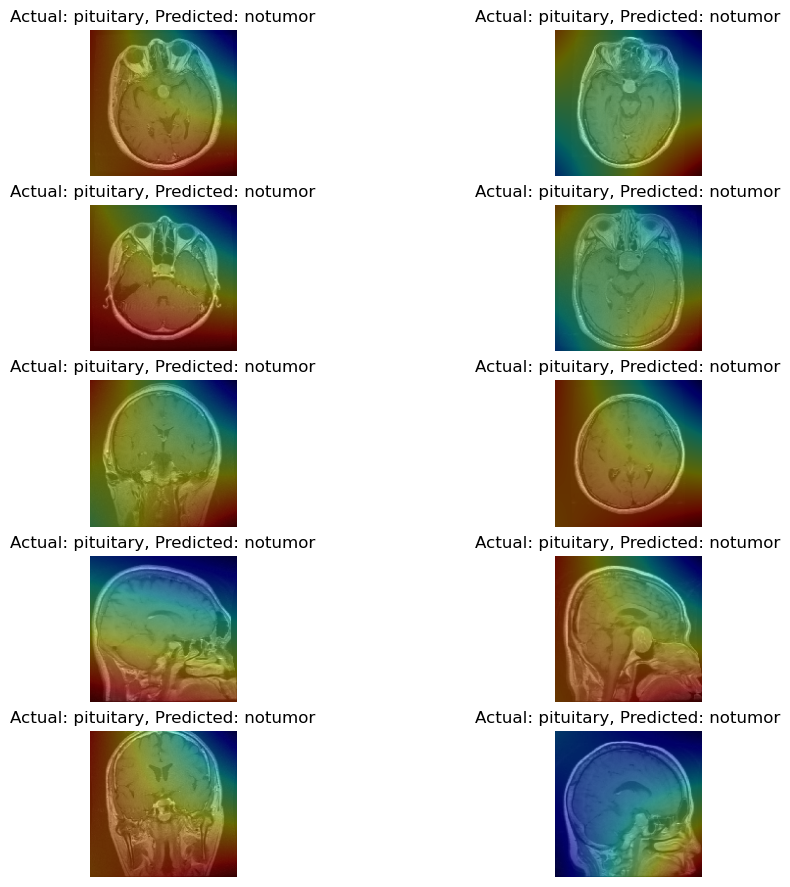

In [80]:
from keras.preprocessing.image import load_img, img_to_array

images = []
for path in image_paths_testing[:10]:
    img = load_img(path, target_size=IMAGE_SIZE)
    img = img_to_array(img) / 255.0
    images.append(img)
images = np.array(images)

predictions = best_model.predict(images)

predicted_classes = np.argmax(predictions, axis=1)

actual_classes = [class_names.index(label) for label in testing_labels[:10]]

gradcam = Gradcam(best_model, model_modifier=ReplaceToLinear())

plt.figure(figsize=(11, 11))

for i, (image, actual_class, predicted_class) in enumerate(zip(images, actual_classes, predicted_classes)):
    loss = CategoricalScore(predicted_class)
    heatmap = gradcam(loss, np.array([image]), penultimate_layer=-1)

    plt.subplot(5, 2, i + 1)
    
    plt.imshow(image, alpha=1.0)
    
    plt.imshow(heatmap[0], cmap='jet', alpha=0.4)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.show()